In [1]:
import nglview as nv
import glob
import mdtraj as md
import os

In [2]:
trj_dir = 'ADPSweep/gen=256_dis=256_latent=128_genNet=simple_disNet=simple_opt=rmsprop/trjs/trj*xyz'

In [3]:
trj_fnames = glob.glob(trj_dir)
trj_fnames.sort(key=os.path.getmtime)
len(trj_fnames)

100

In [4]:
full_trj = md.load('data_mdshare/alanine-dipeptide-nowater.pdb')
full_trj

<mdtraj.Trajectory with 1 frames, 22 atoms, 3 residues, and unitcells at 0x7f2be7614470>

In [5]:
cond_trj = full_trj.atom_slice(full_trj.top.select('backbone'))

In [6]:
trj = md.load(trj_fnames[-1], top=cond_trj.top)
trj

<mdtraj.Trajectory with 250000 frames, 8 atoms, 3 residues, without unitcells at 0x7f2be752fb38>

In [7]:
v = nv.show_mdtraj(trj)
v.clear_representations()
v.add_representation('ball+stick')
v

NGLWidget(max_frame=249999)

In [8]:
from GAN_datamodule import AlanineDipeptide

In [9]:
data = AlanineDipeptide()

Using 2 trajectories for training consisting of 500000 frames
Using 1 trajectories for evaluation consisting of 250000 frames


In [10]:
# compare reconstructed traj against conditioning
from nglview import NGLWidget
view = NGLWidget()
view.add_trajectory(data.val_cond_trj)
view.add_trajectory(trj)
op_list = [0.4, 1.0]
for v, op in zip(view, op_list):
    v.clear_representations()
    v.add_representation('ball+stick', opacity=op)
view

NGLWidget(max_frame=249999)

In [20]:
import pickle as pkl
import numpy as np
from copy import deepcopy

In [14]:
ddpm = pkl.load(open('/project/andrewferguson/Mike/geometric_deep_learning/DDPM/test_trajs/adp.pkl','rb'))

In [16]:
data.val_cond_trj

<mdtraj.Trajectory with 250000 frames, 8 atoms, 3 residues, and unitcells at 0x7f2b09f7cf98>

In [17]:
ddpm.center_coordinates()

<mdtraj.Trajectory with 250000 frames, 8 atoms, 3 residues, without unitcells at 0x7f2b092b0b38>

In [18]:
trj.center_coordinates()

<mdtraj.Trajectory with 250000 frames, 8 atoms, 3 residues, without unitcells at 0x7f2be752fb38>

In [21]:
val_trj = deepcopy(data.val_cond_trj.center_coordinates())

In [22]:
combined_top = val_trj.top.join(trj.top).join(ddpm.top)
combined_top

<mdtraj.Topology with 3 chains, 9 residues, 24 atoms, 21 bonds at 0x7f2b09f7ca20>

In [60]:
gan_xyz = trj.xyz + np.array([[0, 0.75, 0]])
ddpm_xyz = ddpm.xyz + np.array([[0, 1.5, 0]])

In [61]:
combined_xyz = np.concatenate((val_trj.xyz, gan_xyz, ddpm_xyz), 1)
combined_xyz.shape

(250000, 24, 3)

In [62]:
combined_trj = md.Trajectory(combined_xyz, topology=combined_top)

In [63]:
v = nv.show_mdtraj(combined_trj)
v.clear_representations()
v.add_representation('ball+stick')
v

NGLWidget(max_frame=249999)

In [11]:
import numpy as np
from scipy.spatial.distance import pdist

In [12]:
pdists_real = np.concatenate([pdist(xyz)[None] for xyz in data.val_cond_trj.xyz])
pdists_fake = np.concatenate([pdist(xyz)[None] for xyz in trj.xyz])

In [13]:
phi_real = md.compute_phi(data.val_cond_trj)[1].flatten()
psi_real = md.compute_psi(data.val_cond_trj)[1].flatten()

phi_fake = md.compute_phi(trj)[1].flatten()
psi_fake = md.compute_psi(trj)[1].flatten()

In [14]:
import pyemma as py
import matplotlib.pyplot as plt

(<Figure size 432x288 with 2 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f6b7489c518>)

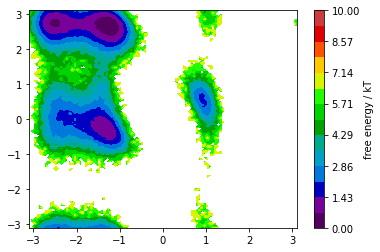

In [15]:
py.plots.plot_free_energy(phi_real, psi_real, levels=np.linspace(0, 10, 15))

(<Figure size 432x288 with 2 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f6b746eeda0>)

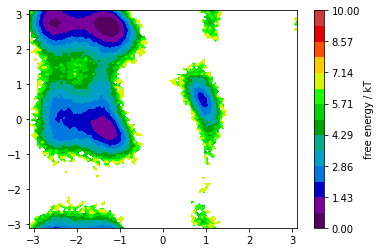

In [16]:
py.plots.plot_free_energy(phi_fake, psi_fake, levels=np.linspace(0, 10, 15))

/project/andrewferguson/Kirill/class_project_env/lib/python3.7/site-packages/pyemma/plots/plots2d.py:253: UserWarning: bins=25 is not an allowed optional parameter and will be ignored
  ' be ignored'.format(key, kwargs[key]))


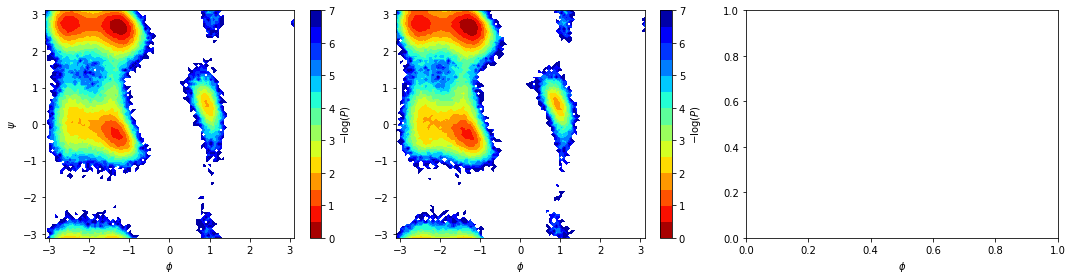

In [17]:

fig, ax = plt.subplots(1, 3, figsize=(15, 4))
ax = ax.flatten()
py.plots.plot_free_energy(phi_real, psi_real, levels=np.linspace(0, 7, 15),
                          bins=25, ax=ax[0], cbar_label=r'$-\log(P)$', cmap='jet_r')
py.plots.plot_free_energy(phi_fake, psi_fake,  levels=np.linspace(0, 7, 15),
                          bins=25, ax=ax[1], cbar_label=r'$-\log(P)$', cmap='jet_r')
x_lim = ax[0].get_xlim()
y_lim = ax[0].get_ylim()
ax[1].set_xlim(*x_lim)
ax[1].set_ylim(*y_lim)
ax[0].set_ylabel(r'$\psi$')
for a in ax:
    a.set_xlabel(r'$\phi$')
plt.tight_layout()

In [18]:
from scipy.stats import pearsonr

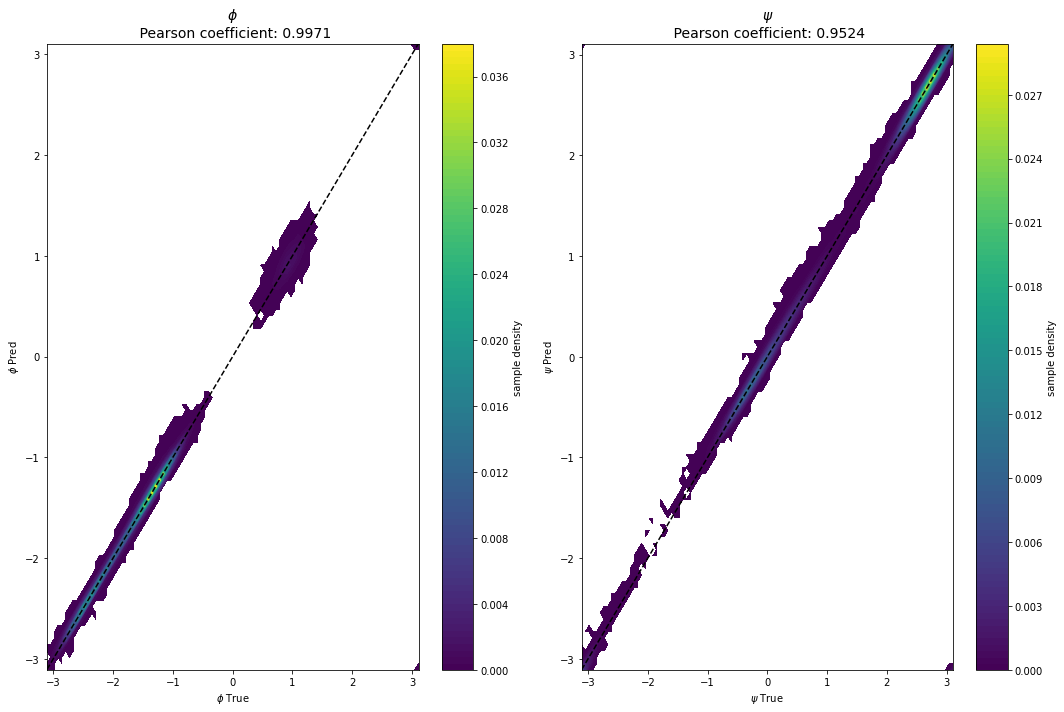

In [19]:
fig, axes = plt.subplots(1,2, figsize=(15, 10))

corrs = list()

ax = axes[0]
py.plots.plot_density(phi_real, phi_fake, ax=ax)
p_phi, _ = pearsonr(phi_real, phi_fake)
corrs.append(p_phi)
ax.set_title(f'$\phi$ \n Pearson coefficient: {p_phi:.4g}', fontsize=14)
ax.set_xlabel(f'$\phi$ True')
ax.set_ylabel(f'$\phi$ Pred')
y_min,y_max = ax.get_ylim()
x_min,x_max = ax.get_xlim()
ax.plot([x_min, y_max], [x_min,y_max], c='k', linestyle='--')

ax = axes[1]
py.plots.plot_density(psi_real, psi_fake, ax=ax)
p_phi, _ = pearsonr(psi_real, psi_fake)
corrs.append(p_phi)
ax.set_title(f'$\psi$ \n Pearson coefficient: {p_phi:.4g}', fontsize=14)
ax.set_xlabel(f'$\psi$ True')
ax.set_ylabel(f'$\psi$ Pred')
y_min,y_max = ax.get_ylim()
x_min,x_max = ax.get_xlim()
ax.plot([x_min, y_max], [x_min,y_max], c='k', linestyle='--')


plt.tight_layout()

In [20]:
np.mean(corrs)

0.9747562887813004

In [21]:
def empirical_correlation(x, y):
    xc = x - np.mean(x, axis=0)
    yc = y - np.mean(y, axis=0)
    corr = np.mean(xc*yc, axis=0)/(np.std(x, axis=0)*np.std(y, axis=0))
    return corr


def generate_its(data, lags):
    its = []
    for lag in lags: 
        if type(data) is list:
            x0 = np.concatenate([item[:-lag] for item in data])
            x1 = np.concatenate([item[lag:] for item in data])
        else:
            x0 = data[:-lag]
            x1 = data[lag:]
        ts = empirical_correlation(x0, x1)
        its.append(-lag/np.log(np.abs(ts)))
    
    return np.array(its)

In [22]:
lags = [1,5,10,15,20,25,30,35,40,45,50, 75 ,100, 150, 200, 250, 500, 1000, 1500]

In [23]:
phi_psi_real = np.concatenate((phi_real[:,None],psi_real[:,None],),-1)
phi_psi_fake = np.concatenate((phi_fake[:,None],psi_fake[:,None],),-1)

In [24]:
real_its = generate_its(phi_psi_real, lags)
fake_its = generate_its(phi_psi_fake, lags)

Text(0.5, 0, 'Lag time')

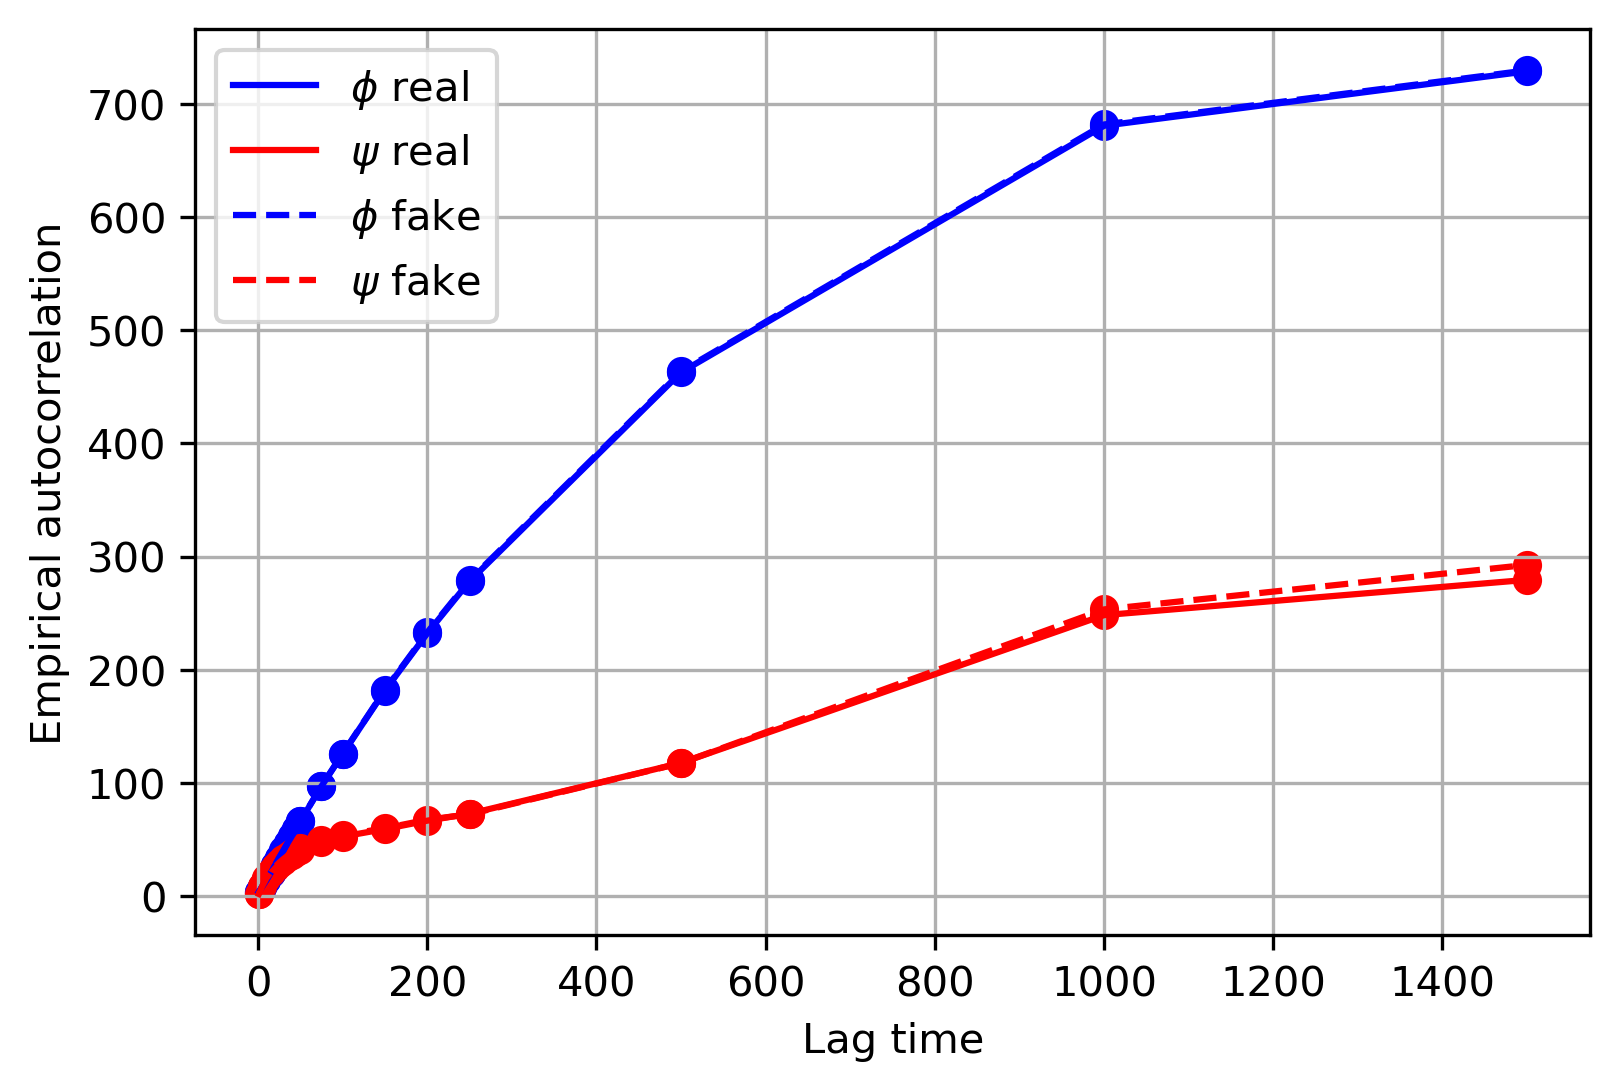

In [25]:
plt.figure(dpi=300)
colors = ['b','r', 'g', 'k']
for i in range(real_its.shape[1]):
    plt.plot(lags,real_its[:, i], label='$\phi$ real' if i==0 else '$\psi$ real', c=colors[i])
    plt.scatter(lags,real_its[:, i], c=colors[i])

for i in range(fake_its.shape[1]):
    plt.plot(lags,fake_its[:, i], label='$\phi$ fake' if i==0 else '$\psi$ fake', linestyle='--', c=colors[i])
    plt.scatter(lags,fake_its[:, i], c=colors[i])

plt.legend()
plt.grid()
plt.ylabel('Empirical autocorrelation')
plt.xlabel('Lag time')

In [92]:
trj_ref = data.val_cond_trj
all_bonds = [(b[0].index, b[1].index) for b in trj.top.bonds]
bond_dists_r = md.compute_distances(trj_ref, all_bonds)
bond_dists_s = md.compute_distances(trj, all_bonds)
bond_rmsd = np.sqrt(np.mean((bond_dists_s - bond_dists_r) ** 2))
bond_rmsd

0.0039013976

In [93]:
min_r, max_r = np.min(bond_dists_r, axis=0), np.max(bond_dists_r, axis=0)
correct_aa = np.sum((bond_dists_s < max_r) & (bond_dists_s > min_r), axis=1)
auc_aa = []
for i in range(len(all_bonds)):
    auc = np.mean(correct_aa > i)
    auc_aa.append(auc)
print(np.sum(auc_aa) / len(all_bonds))

0.9998165714285714


In [96]:
from tqdm.autonotebook import tqdm

In [97]:
frames = list()
for t in tqdm(trj_fnames):
    frame = md.load(t, top=trj.top)[0]
    frames.append(frame)

  0%|          | 0/100 [00:00<?, ?it/s]

In [98]:
frames_trj = md.join(frames).center_coordinates()

In [99]:
frames_trj.save_pdb('frame_adp_trj.pdb')

In [100]:
md.load('data_mdshare/alanine-dipeptide-nowater.pdb').center_coordinates().save_pdb('adp_pdb_center.pdb')